## Task 1: Deconvolution Gaussian Prior (50 pts)

Implement deconvolution with Gaussian Prior in the frequency domain. You can ignore the
artefacts at the boundaries. You have the paper here http://groups.csail.mit.edu/graphics/
CodedAperture/.

You also have some details about implementation in here
http://groups.csail.mit.edu/graphics/CodedAperture/SparseDeconv-LevinEtAl07.pdf

You have to implement section 2. The formula 8.

DATA: http://groups.csail.mit.edu/graphics/CodedAperture/CodedAperture-Data-LevinEtAl.zip

In [1]:
from IPython.display import Image
import numpy as np
import cv2
import scipy.io
from lib.display_helper import *
from lib.log import log_message

def compute_prior_L2_frequency(I):
    if len(I.shape) == 3:
        (n, m, c) = I.shape
    elif len(I.shape) == 2:
        (n, m) = I.shape
    else:
        raise NotImplementedError("Implemented for image with shape (h,w,c) or (h,w)")
    Gx = np.fft.fft2(np.array([[-1,1]]), (n,m))
    Gy = np.fft.fft2(np.array([[-1],[1]]), (n,m))
    if len(I.shape) == 3:
        Gx = np.repeat(Gx[...,None], c, axis=-1)
        Gy = np.repeat(Gy[...,None], c, axis=-1)
    return Gx, Gy

# kernel size is expected to be odd in both dimensions 
def deconvolution_L2_frequency(I, F, Gx, Gy, weight):
    A = np.conj(F)*F + weight*(np.conj(Gx)*Gx + np.conj(Gy)*Gy);
    b = np.conj(F)*I;
    X = b/A;
    
    if len(I.shape) == 3:
        x = np.fft.ifft2(X, axes=(-3, -2));
    elif len(I.shape) == 2:
        x = np.fft.ifft2(X);
    else:
        raise NotImplementedError("Implemented for image with shape (h,w,c) or (h,w)")
    return x.real.clip(0,255).astype(np.uint8)

def flip_kernel(kernel):
    return np.fliplr(np.flipud(kernel))

def deconvolution_L2(image, kernels):
    log_message("Making border for filtering...")
    max_fh = max(kernels, key=lambda x: x.shape[0]).shape[0]
    max_fw = max(kernels, key=lambda x: x.shape[1]).shape[1]
    (hfh, hfw) = (max_fh-1)/2, (max_fw-1)/2
    img_bord = cv2.copyMakeBorder(image,hfh,hfh,hfw,hfw,cv2.BORDER_REFLECT_101)
    
    log_message("Initializing data in frequency domain...")
    
    if len(img_bord.shape) == 3:
        image_fd = np.fft.fft2(img_bord, axes=(-3,-2))
        (n, m, c) = img_bord.shape
        kernels_fd = np.array([np.fft.fft2(k, (n, m)) for k in kernels])
        kernels_fd = np.repeat(kernels_fd[...,None], 3, axis=-1)
    elif len(img_bord.shape) == 2:
        image_fd = np.fft.fft2(img_bord)
        (n, m) = img_bord.shape
        kernels_fd = np.array([np.fft.fft2(k, (n, m)) for k in kernels])
    else:
        raise NotImplementedError("Implemented for image with shape (h,w,c) or (h,w)")
    
    log_message("Computing Gaussian Prior in frequency domain...")
    Gx, Gy = compute_prior_L2_frequency(image_fd)

    log_message("Computing deconvolution in frequency domain...")
    outputs = deconvolution_L2_frequency(image_fd, kernels_fd, Gx, Gy, 0.01)
    
    log_message("Aligning outputs...")
    for i in range (len(kernels)):
        fh, fw = kernels[i].shape[0], kernels[i].shape[1]
        hfh, hfw = fh/2, fw/2
        outputs[i,hfh:,hfw:] = outputs[i,:-hfh:, :-hfw]
    max_hfh, max_hfw = (outputs.shape[1]-image.shape[0])/2, (outputs.shape[2]-image.shape[1])/2
    outputs = outputs[:,max_hfh:-max_hfh,max_hfw:-max_hfw]
    return outputs

In [2]:
matlab_files = [scipy.io.loadmat("CodedApertureData/filts/filt_scl0"+str(i)+".mat") for i in range(1,10)]
kernels = [flip_kernel(ml_file['filts'][0,3]) for ml_file in matlab_files]
image = cv2.imread('CodedApertureData/cups_board_inp.bmp');
image_gray = cv2.imread('CodedApertureData/cups_board_inp.bmp', 0);

#### Version 1: Same process for three color channels.

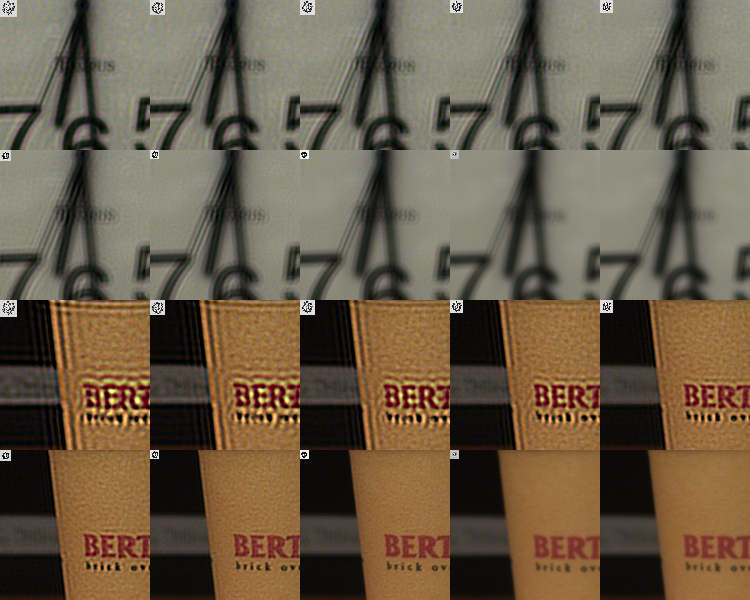

In [3]:
outputs = deconvolution_L2(image, kernels)

for i in range(len(kernels)):
    cv2.imwrite('output/task1/color_'+str(max(kernels[i].shape))+'.png', outputs[i])

from lab6_display import display_cups_board_color_output
disp_path = 'output/task1_crop_color.png'
display_cups_board_color_output(image, outputs, kernels, disp_path)
Image(disp_path)

#### Version 2: Deconvolution for grayscale image and color transfer from blurred.

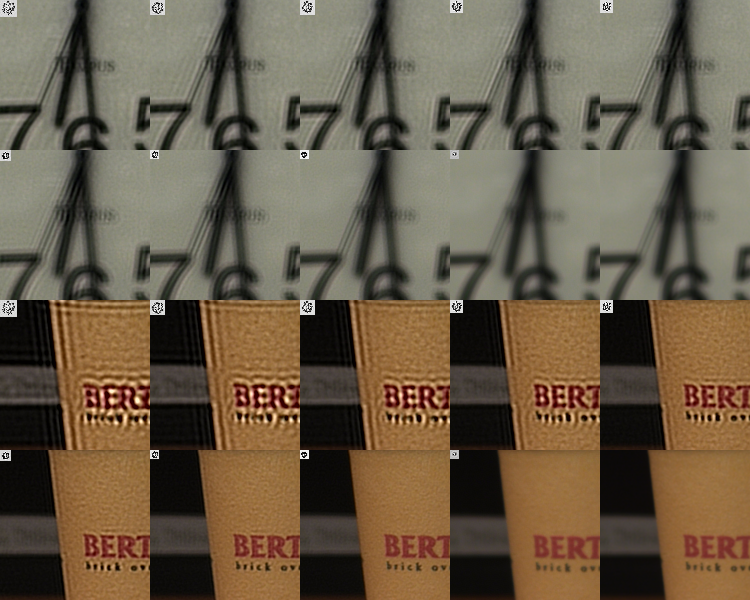

In [4]:
outputs_gray = deconvolution_L2(image_gray, kernels)

from lib.colors import transfer_color
outputs_colorized = []
for i in range(len(kernels)):
    cv2.imwrite('output/task1/gray_'+str(max(kernels[i].shape))+'.png', outputs_gray[i])
    outputs_colorized.append(transfer_color(image, outputs_gray[i]))
    cv2.imwrite('output/task1/colorized_'+str(max(kernels[i].shape))+'.png', outputs_colorized[i])

from lab6_display import display_cups_board_color_output
disp_path = 'output/task1_crop_colorized.png'
display_cups_board_color_output(image, np.array(outputs_colorized), kernels, disp_path)
Image(disp_path)

## Task 3: Deconvolution Sparse Prior Spatial domain (70 pts)
This is a more complicated to implement method and requires a gradient descent implementation. However you have all the details and code in files linked above.

The results should be quite better, compare to task 1.

In [5]:
from scipy.signal import convolve2d, fftconvolve
from lib.log import log_progress

# translated matlab code from:
# http://groups.csail.mit.edu/graphics/CodedAperture/DeconvolutionCode.html
def deconvSps(image,kernel,weight,max_it=200):
    (n,m) = image.shape
    (fh,fw) = kernel.shape
    hfh, hfw = (fh-1)/2, (fw-1)/2
    m = m + 2*hfw
    n = n + 2*hfh
    N = m*n

    img_cp = image.copy()
    image = np.zeros((n,m), np.float64)
    image[hfh:n-hfh,hfw:m-hfw] = img_cp
    x = image.copy();

    dxf  = np.array([[1, -1]], np.float64)
    dyf  = np.array([[1],[-1]], np.float64)
    dyyf = np.array([[-1], [2], [-1]], np.float64)
    dxxf = np.array([[-1, 2, -1]], np.float64)
    dxyf = np.array([[-1, 1], [1, -1]], np.float64)
    
    weight_x  = np.ones((n,m-1), np.float64)
    weight_y  = np.ones((n-1,m), np.float64)
    weight_yy = np.ones((n-2,m), np.float64)
    weight_xx = np.ones((n,m-2), np.float64)
    weight_xy = np.ones((n-1,m-1), np.float64)

    x = deconvL2_w(x[hfh:n-hfh,hfw:m-hfw],kernel,weight,max_it,weight_x,weight_y,weight_xx,weight_yy,weight_xy)

    w0 = 0.1
    exp_a = 0.8
    thr_e = 0.01

    for t in range(2):
        dy  = np.abs(fftconvolve(x,flip_kernel(dyf),mode='valid')).clip(thr_e, float("inf"))
        dx  = np.abs(fftconvolve(x,flip_kernel(dxf),mode='valid')).clip(thr_e, float("inf"))
        dyy = np.abs(fftconvolve(x,flip_kernel(dyyf),mode='valid')).clip(thr_e, float("inf"))
        dxx = np.abs(fftconvolve(x,flip_kernel(dxxf),mode='valid')).clip(thr_e, float("inf"))
        dxy = np.abs(fftconvolve(x,flip_kernel(dxyf),mode='valid')).clip(thr_e, float("inf"))
        
        weight_x  = w0*dx**(exp_a-2)
        weight_y  = w0*dy**(exp_a-2)
        weight_xx = 0.25*w0*dxx**(exp_a-2)
        weight_yy = 0.25*w0*dyy**(exp_a-2)
        weight_xy = 0.25*w0*dxy**(exp_a-2)
          
        x = deconvL2_w(image[hfh:n-hfh,hfw:m-hfw],kernel,weight,max_it,weight_x,weight_y,weight_xx,weight_yy,weight_xy)

    x = x[hfh:n-hfh,hfw:m-hfw]

    return x

def deconvL2_w(image,kernel,weight,max_it,weight_x,weight_y,weight_xx,weight_yy,weight_xy):
    (n,m) = image.shape
    (fh,fw) = kernel.shape
    hfh, hfw = (fh-1)/2, (fw-1)/2
    m = m + 2*hfw
    n = n + 2*hfh
    N = m*n

    mask = np.zeros((n,m), np.float64)
    mask[hfh:n-hfh,hfw:m-hfw] = 1.

    img_cp = image.copy()
    image = np.zeros((n,m), np.float64)
    image[hfh:n-hfh,hfw:m-hfw] = img_cp
    x = image.copy();
    
    b = fftconvolve(x*mask, kernel, mode='same')

    dxf  = np.array([[1, -1]], np.float64)
    dyf  = np.array([[1],[-1]], np.float64)
    dxxf = np.array([[-1, 2, -1]], np.float64)
    dyyf = np.array([[-1], [2], [-1]], np.float64)
    dxyf = np.array([[-1, 1], [1, -1]], np.float64)
    
    if max(kernel.shape) < 25:
        Ax = fftconvolve(fftconvolve(x,flip_kernel(kernel),mode='same')*mask,kernel,mode='same')
    else:
        Ax = fftconvolve(fftconvolve(x,flip_kernel(kernel),mode='same')*mask, kernel,mode='same')
    
    Ax += weight*fftconvolve(weight_x*fftconvolve(x,flip_kernel(dxf),mode='valid'), dxf)
    Ax += weight*fftconvolve(weight_y*fftconvolve(x,flip_kernel(dyf),mode='valid'), dyf)
    Ax += weight*fftconvolve(weight_xx*fftconvolve(x,flip_kernel(dxxf),mode='valid'), dxxf)
    Ax += weight*fftconvolve(weight_yy*fftconvolve(x,flip_kernel(dyyf),mode='valid'), dyyf)
    Ax += weight*fftconvolve(weight_xy*fftconvolve(x,flip_kernel(dxyf),mode='valid'), dxyf)

    r = b - Ax
    
    for iteration in range(max_it):
        rho = np.dot(r.flatten(), r.flatten())
        # direction vector
        if iteration > 0:
            beta = rho / rho_1
            p = r + beta*p
        else:
            p = r.copy()
        if max(kernel.shape) < 25:
            Ap = fftconvolve(fftconvolve(p,flip_kernel(kernel),mode='same')*mask,kernel,mode='same')
        else:
            Ap = fftconvolve(fftconvolve(p,flip_kernel(kernel),mode='same')*mask,kernel,mode='same')

        Ap += weight*fftconvolve(weight_x*fftconvolve(p,flip_kernel(dxf),mode='valid'),dxf)
        Ap += weight*fftconvolve(weight_y*fftconvolve(p,flip_kernel(dyf),mode='valid'),dyf)
        Ap += weight*fftconvolve(weight_xx*fftconvolve(p,flip_kernel(dxxf),mode='valid'),dxxf)
        Ap += weight*fftconvolve(weight_yy*fftconvolve(p,flip_kernel(dyyf),mode='valid'),dyyf)
        Ap += weight*fftconvolve(weight_xy*fftconvolve(p,flip_kernel(dxyf),mode='valid'),dxyf)

        q = Ap.copy()

        denominator = np.dot(p.flatten(), q.flatten())
        if abs(denominator) < 10**-6:
            #print '> denominator = 0 in', iteration, 'iteration'
            return x

        alpha = rho / denominator
        
        # update approximation vector
        x = x + alpha*p

        # compute residual
        r = r - alpha*q
        rho_1 = rho

    return x

#### Version 1: Same process for three color channels.

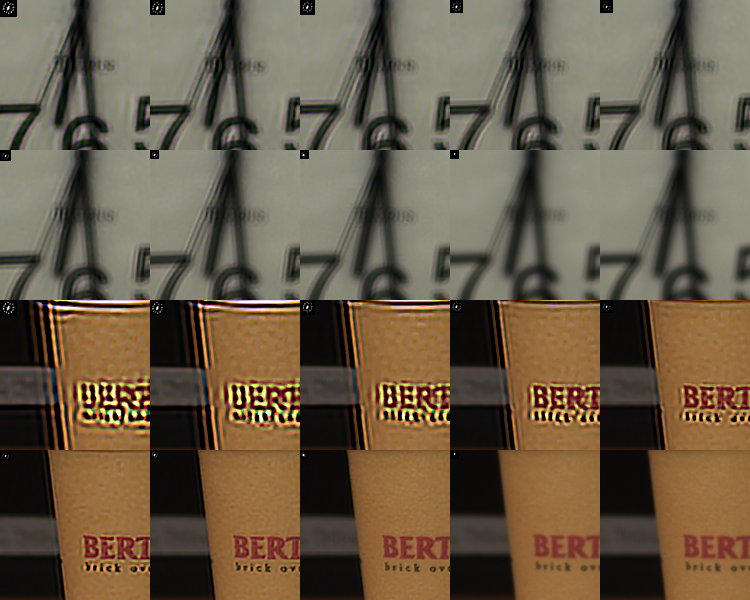

In [7]:
output_paths = ['output/task3/color_300_300_'+str(i)+'.png' for i in range(len(kernels))]
outputs = []
for i in log_progress(range(len(kernels)), every=1):
    output = np.zeros(image.shape, np.float64)
    output[...,0] = deconvSps(image[...,0].copy(), kernels[i], 0.3, 300)
    output[...,1] = deconvSps(image[...,1].copy(), kernels[i], 0.3, 300)
    output[...,2] = deconvSps(image[...,2].copy(), kernels[i], 0.3, 300)
    outputs.append(output.copy())
    cv2.imwrite(output_paths[i], output)
outputs = np.array(outputs)

from lab6_display import display_cups_board_color_output
disp_path = 'output/task3_crop_color.png'
display_cups_board_color_output(image, outputs, kernels, disp_path)
Image(disp_path)

#### Version 2: Deconvolution for grayscale image and color transfer from blurred.

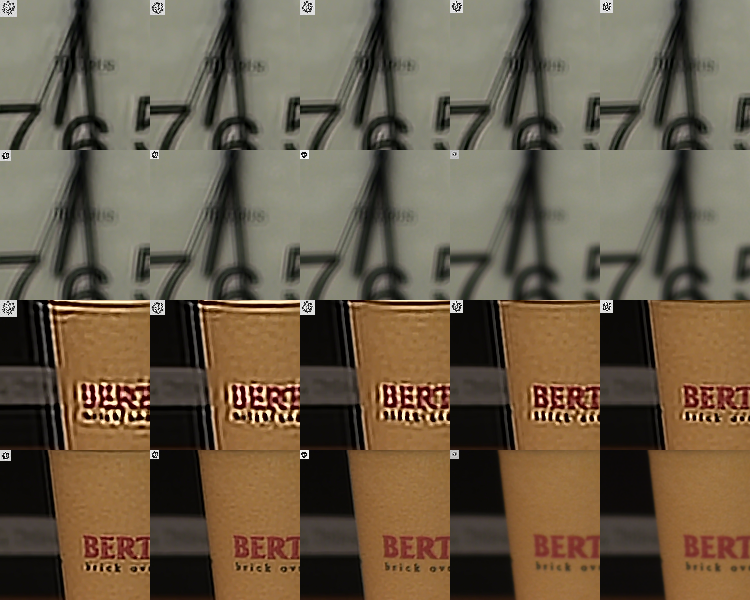

In [8]:
from lib.colors import transfer_color

output_gray_paths = ['output/task3/gray_300_300_'+str(i)+'.png' for i in range(len(kernels))]
output_colorized_paths = ['output/task3/colorized_300_300_'+str(i)+'.png' for i in range(len(kernels))]
gray_outputs = []
colorized_outputs = []
for i in log_progress(range(len(kernels)), every=1):
    output = deconvSps(image_gray, kernels[i], 0.3, 300)
    gray_outputs.append(output.copy())
    cv2.imwrite(output_gray_paths[i], output)
    output_colorized = transfer_color(image, output.clip(0,255).astype(image.dtype))
    colorized_outputs.append(output_colorized.copy())
    cv2.imwrite(output_colorized_paths[i], output_colorized)
colorized_outputs = np.array(colorized_outputs)

from lab6_display import display_cups_board_color_output
disp_path = 'output/task3_crop_colorized.png'
display_cups_board_color_output(image, colorized_outputs, kernels, disp_path)
Image(disp_path)